In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cvx.covariance.ewma import iterated_ewma, _ewma_mean
from cvx.covariance.combination import from_sigmas
from cvx.covariance.regularization import regularize_covariance, em_regularize_covariance
from experiments.utils.experiment_utils import *
from experiments.utils.factor_model import *

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

In [319]:
returns = pd.read_csv("../data/returns_large_universe.csv", index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [331]:
def ecdf(series):
    n = np.arange(1,len(series)+1) / len(series)
    Xs = np.sort(series)
    plt.step(Xs,n) 
    return Xs

def ecdf_trailing(data, quantiles=[0.2, 0.4, 0.5, 0.6, 0.8]):
    series = data.values.copy()


    series.sort(axis=1)
    # get quantiles

    quant = np.quantile(series, quantiles, axis=1)
    quant = quant - quant[2]

    return ecdf(series.mean(axis=0)), quant

In [278]:
data = returns.iloc[i:i+freq]
series = data.values.copy()


series.sort(axis=1)

In [281]:
quantiles = np.quantile(series, [0.2, 0.5, 0.8], axis=1)

In [273]:
series.shape

(125, 238)

In [277]:
quantiles

array([[-0.0027492],
       [ 0.003609 ],
       [ 0.0105656]])

In [274]:
np.quantile(series, [0.2, 0.5, 0.8], axis=1)

array([[-1.102652e-01, -7.898240e-02, -6.825400e-02, -6.079860e-02,
        -5.769520e-02, -5.267700e-02, -5.093740e-02, -4.814020e-02,
        -4.636760e-02, -4.551440e-02, -4.479020e-02, -4.301500e-02,
        -4.160840e-02, -4.126480e-02, -3.912820e-02, -3.830940e-02,
        -3.715880e-02, -3.643560e-02, -3.585460e-02, -3.550360e-02,
        -3.457580e-02, -3.433420e-02, -3.425820e-02, -3.368360e-02,
        -3.299240e-02, -3.251240e-02, -3.214500e-02, -3.117540e-02,
        -3.075740e-02, -3.041000e-02, -2.949560e-02, -2.890700e-02,
        -2.862640e-02, -2.822900e-02, -2.745320e-02, -2.726940e-02,
        -2.699020e-02, -2.632300e-02, -2.586870e-02, -2.554160e-02,
        -2.543580e-02, -2.536560e-02, -2.519480e-02, -2.500040e-02,
        -2.441860e-02, -2.422980e-02, -2.401200e-02, -2.370000e-02,
        -2.347440e-02, -2.326580e-02, -2.308080e-02, -2.272120e-02,
        -2.260320e-02, -2.204040e-02, -2.198460e-02, -2.187840e-02,
        -2.179640e-02, -2.139060e-02, -2.112540e

In [289]:
quantiles

array([[-0.0027492],
       [ 0.003609 ],
       [ 0.0105656]])

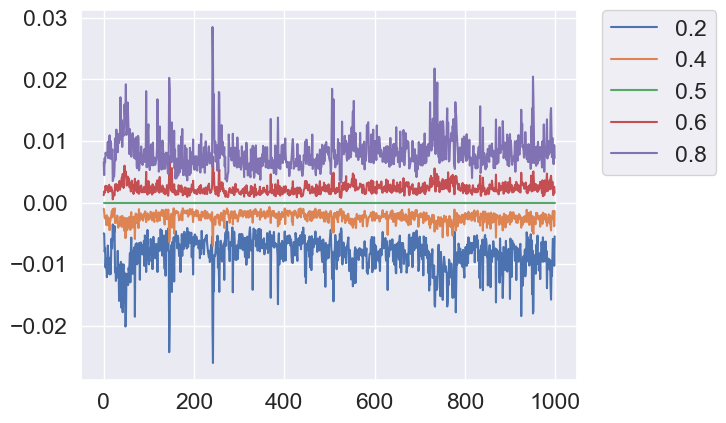

In [337]:
plt.plot(quantiles.T, label=[0.2,0.4, 0.5, 0.6,0.8]);
# put legend outside of the plot\
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [340]:
p=1
d=365
q = p**3+(-6+18*d**2*np.log(2)) / 6
r=2/3

In [342]:
(q+(q**2+(r-p**2)**3)**(1/2))**(1/3) + (q-(q**2+(r-p**2)**3)**(1/2))**(1/3) + p

83.13764937570768

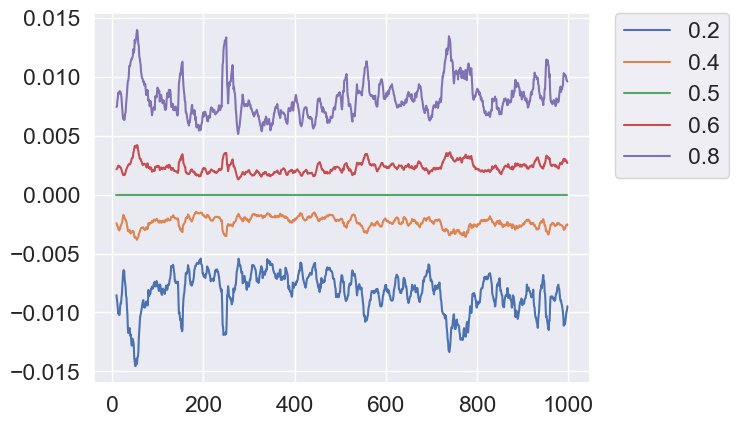

In [339]:
plt.plot(pd.DataFrame(quantiles.T).rolling(10).mean(), label=[0.2,0.4, 0.5, 0.6,0.8]);
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

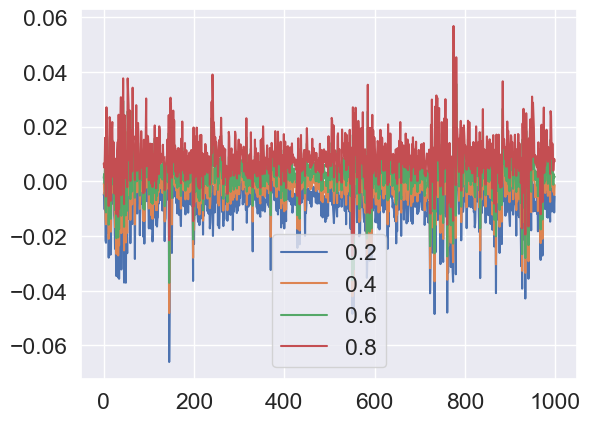

In [321]:
plt.plot(quantiles.T, label=[0.2,0.4,0.6,0.8]);
plt.legend();

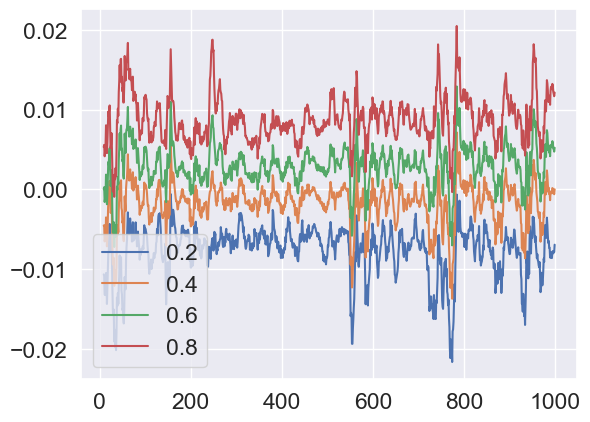

In [323]:
plt.plot(pd.DataFrame(quantiles.T).rolling(10).mean(), label=[0.2,0.4,0.6,0.8]);
plt.legend();

In [335]:
quantiles.shape

(5, 1000)

Text(0.5, 1.0, 'CDFs for five consequent 125-day periods')

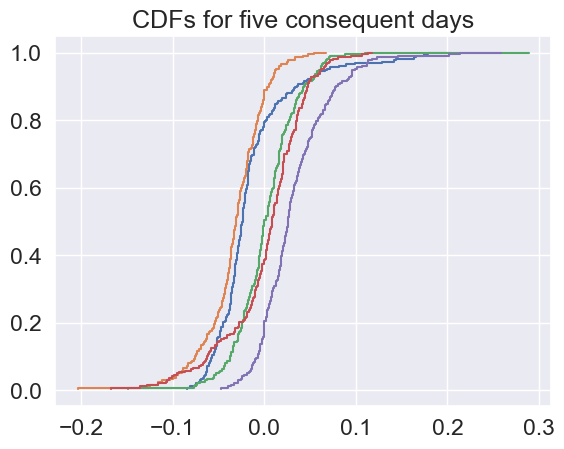

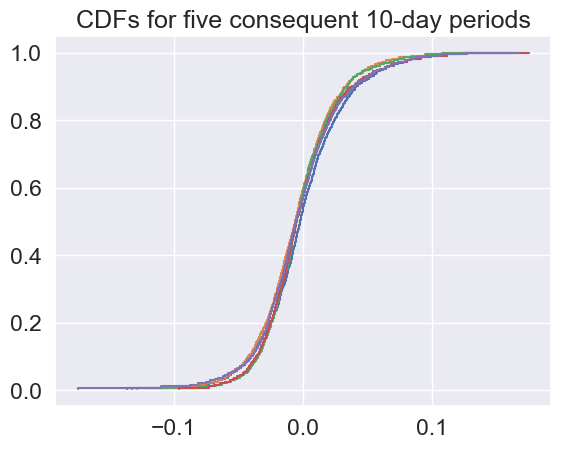

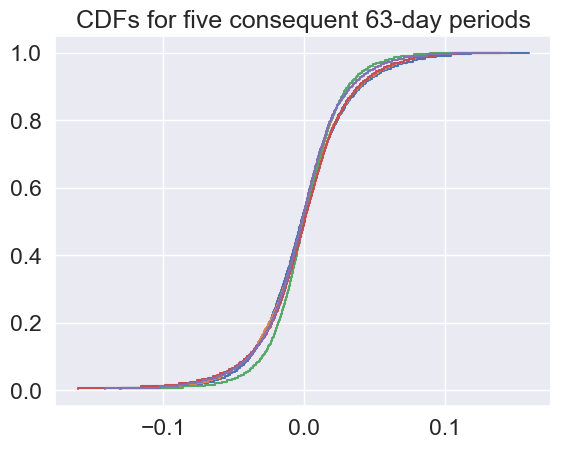

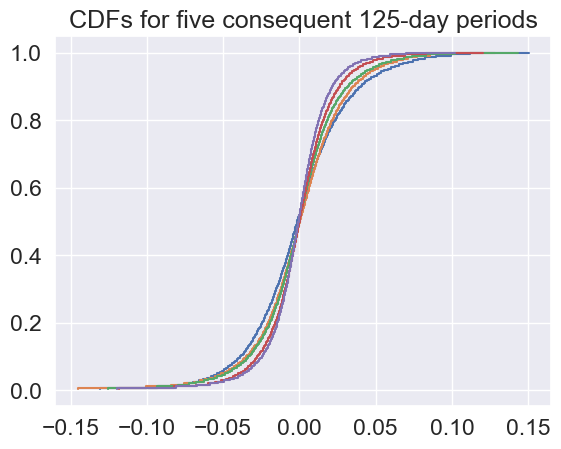

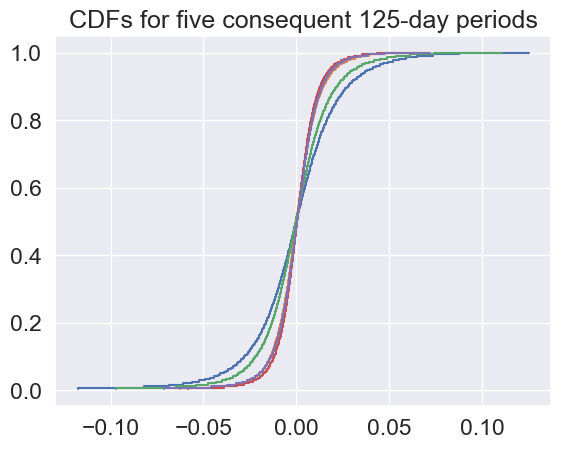

In [332]:
# do ecdf_trailing() on every tenth row
plt.figure()
freq = 1
for i in range(0, 5*freq, freq):
    _, quantiles = ecdf_trailing(returns.iloc[i:i+freq])
plt.title("CDFs for five consequent days")

plt.figure()
freq = 10
for i in range(0, 5*freq, freq):
    _, quantiles = ecdf_trailing(returns.iloc[i:i+freq])
plt.title("CDFs for five consequent 10-day periods")

plt.figure()
freq = 63
for i in range(0, 5*freq, freq):
    _, quantiles = ecdf_trailing(returns.iloc[i:i+freq])
plt.title("CDFs for five consequent 63-day periods")

plt.figure()
freq = 125
for i in range(0, 5*freq, freq):
    _, quantiles = ecdf_trailing(returns.iloc[i:i+freq])
plt.title("CDFs for five consequent 125-day periods")

plt.figure()
freq = 1000
for i in range(0, 5*freq, freq):
    _, quantiles = ecdf_trailing(returns.iloc[i:i+freq])
plt.title("CDFs for five consequent 125-day periods")

In [176]:
returns.iloc[0].sort_values()

6391    -0.084706
9245    -0.080729
20265   -0.075000
21110   -0.074286
10408   -0.071594
           ...   
21551    0.163344
12583    0.165440
15473    0.174056
12793    0.179007
10303    0.203125
Name: 2000-01-03 00:00:00, Length: 238, dtype: float64